In [2]:
import sys
sys.path.append('/home/flint/diplom/experiments')

In [3]:
import compiler_gym
import gym
import pandas as pd
import torch
from compiler_gym import CompilerEnv
from tabulate import tabulate
from tqdm import tqdm

from config.config import TrainConfig
from env.cfg_grind import compile_and_get_instructions
from runtime_eval.jotai.eval import measure_execution_mean_and_std
from utils import (
    get_agent,
    get_model_path,
    optimize_with_model,
)
from config.action_config import *

import matplotlib.pyplot as plt
import numpy as np

MODEL_ITERS = 10
RUNTIME_COUNT = 30
BIN_NAME = "tmp_o3_cbench_test_cfg_grind_bin"
# RUN_TIME = "daily-capybara-88"

In [4]:
def get_speedup(compare_mean, model_mean) -> float:
    return compare_mean / max(model_mean, 1e-12)

In [5]:
env = gym.make("llvm-v0")
benchmarks = list(env.datasets["benchmark://cbench-v1"].benchmarks())

In [6]:
# config = TrainConfig()
# config.algorithm = "LstmDQN"
# config.fc_dim = 128
# config.lstm_hiddem_size = 256
# config.actions = COMPLETE_ACTION_SET
# config.observation_space = "InstCountNorm"
# config.observation_size = 69

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # agent = get_agent(
# #     config,
# #     device,
# #     policy_net_path="/home/flint/diplom/experiments/" + get_model_path(RUN_TIME),
# # )

In [7]:
math_benchs = {
    "qsort",
    "stringsearch",
    "susan",
    "tiff2bw",
    "tiff2rgba",
    "tiffdither",
    "tiffmedian",
}

In [8]:
results = {}

In [11]:
for benchmark in benchmarks:
    benchmark_name = str(benchmark).split('/')[-1]
    print(benchmark_name)
    results[benchmark_name] = []
    with compiler_gym.make("llvm-v0", benchmark=benchmark) as new_env:
        new_env.reset()
        if not new_env.observation["IsRunnable"]:
            print(f"Benchmark {benchmark} not runnable, skip it")
            continue

        try:
            benchmark.validate(new_env)
        except Exception as e:
            benchmark_args = e.msg.split(".bc")[-1].strip()
            cg_working_dir = e.dir

        linkopts = (
            ["-lm"]
            if str(benchmark).rsplit("/", maxsplit=1)[-1] in math_benchs
            else []
        )

        new_env.reset()
        for i in tqdm(range(len(O2_SEQ) + 1)):
            instructions_number = compile_and_get_instructions(
                ir=new_env.observation["Ir"],
                sequence=O3_SEQ[:i],
                result_path=BIN_NAME,
                execution_args=benchmark_args,
                linkopts=linkopts,
            )
            results[benchmark_name].append(instructions_number)
        

adpcm
Benchmark benchmark://cbench-v1/adpcm not runnable, skip it
bitcount


100%|█████████████████████████████████████████| 279/279 [19:30<00:00,  4.20s/it]


blowfish


100%|█████████████████████████████████████████| 279/279 [04:24<00:00,  1.06it/s]


bzip2


100%|█████████████████████████████████████████| 279/279 [18:53<00:00,  4.06s/it]


crc32


100%|█████████████████████████████████████████| 279/279 [05:24<00:00,  1.16s/it]


dijkstra


100%|█████████████████████████████████████████| 279/279 [06:20<00:00,  1.36s/it]


ghostscript
Benchmark benchmark://cbench-v1/ghostscript not runnable, skip it
gsm


100%|█████████████████████████████████████████| 279/279 [08:31<00:00,  1.83s/it]


ispell
Benchmark benchmark://cbench-v1/ispell not runnable, skip it
jpeg-c


100%|█████████████████████████████████████████| 279/279 [19:37<00:00,  4.22s/it]


jpeg-d


100%|█████████████████████████████████████████| 279/279 [20:13<00:00,  4.35s/it]


lame
Benchmark benchmark://cbench-v1/lame not runnable, skip it
patricia


100%|█████████████████████████████████████████| 279/279 [04:28<00:00,  1.04it/s]


qsort


100%|█████████████████████████████████████████| 279/279 [09:21<00:00,  2.01s/it]


rijndael
Benchmark benchmark://cbench-v1/rijndael not runnable, skip it
sha


100%|█████████████████████████████████████████| 279/279 [04:25<00:00,  1.05it/s]


stringsearch


100%|█████████████████████████████████████████| 279/279 [05:15<00:00,  1.13s/it]


stringsearch2


100%|█████████████████████████████████████████| 279/279 [04:42<00:00,  1.01s/it]


susan


100%|█████████████████████████████████████████| 279/279 [08:16<00:00,  1.78s/it]


tiff2bw


100%|█████████████████████████████████████████| 279/279 [20:20<00:00,  4.37s/it]


tiff2rgba


100%|█████████████████████████████████████████| 279/279 [21:50<00:00,  4.70s/it]


tiffdither


100%|█████████████████████████████████████████| 279/279 [22:01<00:00,  4.74s/it]


tiffmedian


100%|█████████████████████████████████████████| 279/279 [23:12<00:00,  4.99s/it]


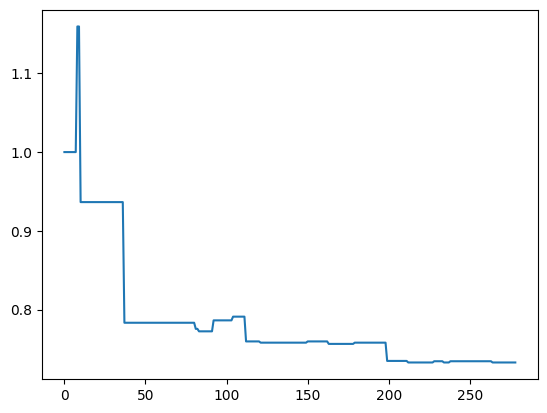

In [13]:
data = np.array(results['bitcount'])
plt.plot(data / data[0])
plt.show()

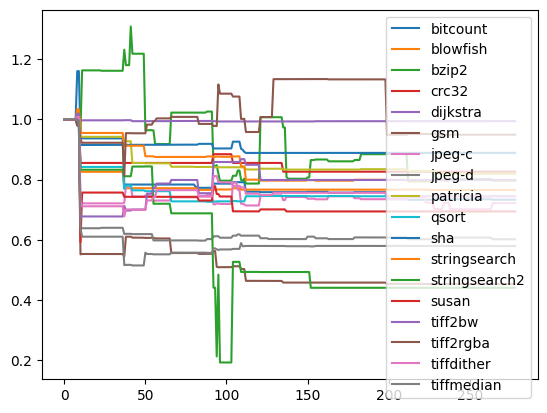

In [14]:
for name, data in results.items():
    if len(data) > 0:
        np_data = np.array(data)
        plt.plot(np_data / np_data[0], label=name)

plt.legend() 
plt.show()

In [15]:
results = {name: data for name, data in results.items() if len(data) > 0}

In [16]:
df = pd.DataFrame(data=results)

In [19]:
df.to_csv("o2_llc_rewards.csv")

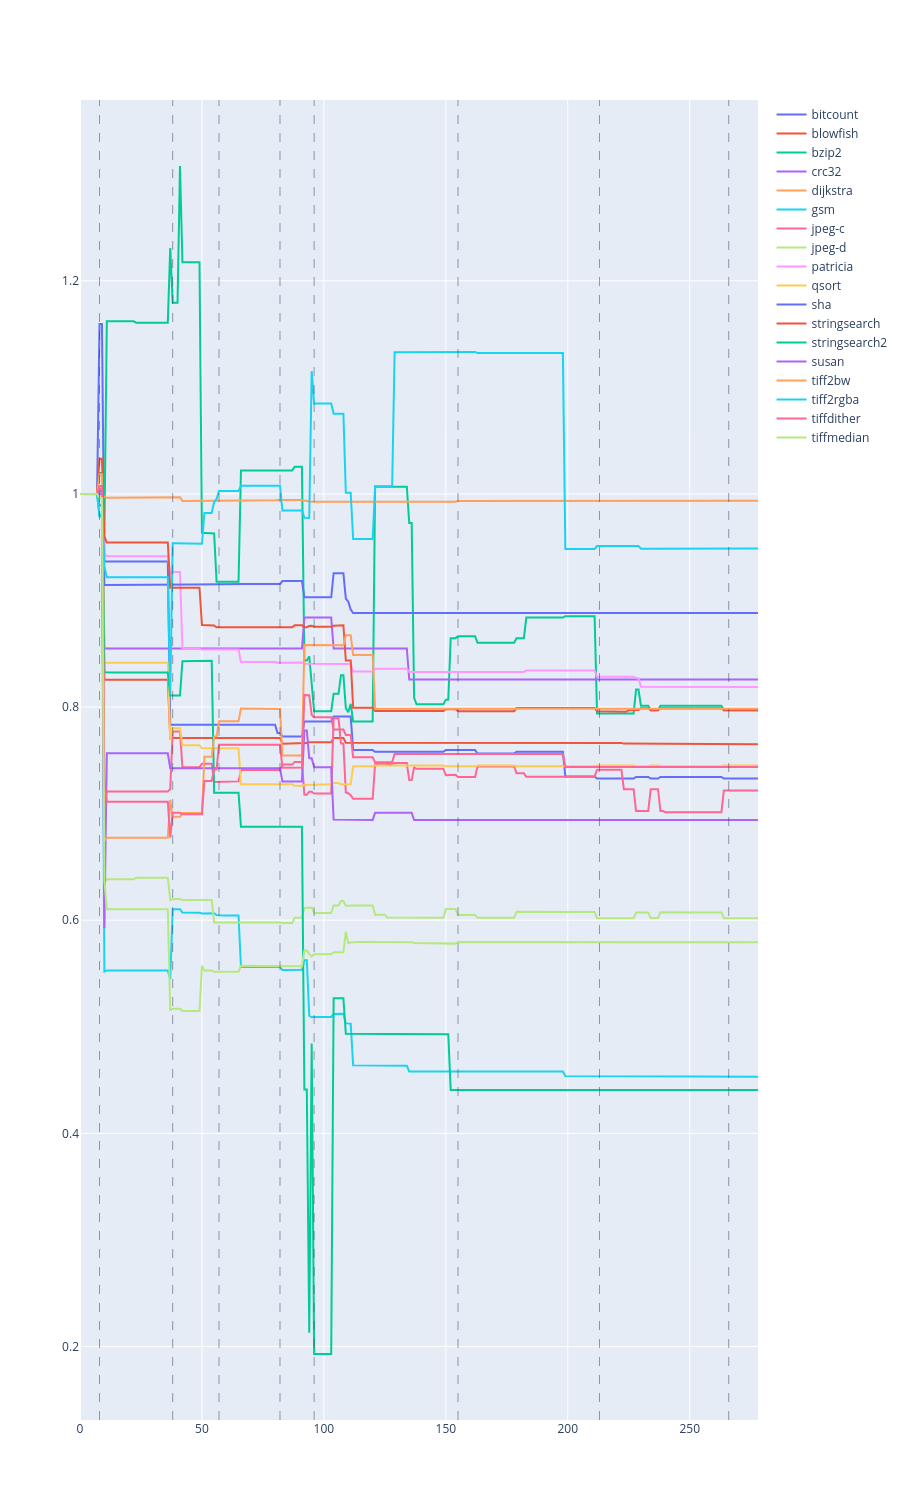

In [62]:
import plotly.graph_objects as go


fig = go.Figure()

for name, data in results.items():
    if len(data) > 0:
        np_data = np.array(data)
        fig.add_trace(go.Scatter(y=np_data / np_data[0],
                    mode='lines',
                    # mode='lines+markers',
                    name=name))

for i in range(len(O3_SEQ)):
    if O3_SEQ[i] == "-simplifycfg":
        fig.add_vline(x=i + 1, line_width=0.5, line_dash="dash")

fig.update_layout(
    # width=1750, height=1000
    width=500, height=1500
)
fig.show()

In [43]:
agmins = []

In [37]:
sorted(set(agmins))

[10, 37, 46, 83, 88, 94, 96, 112, 135, 212, 223, 225, 230, 234, 240]

In [38]:
for i in sorted(set(agmins)):
    # print(O3_SEQ[:i])
    print(O3_SEQ[i - 10:i])

['-tti', '-tbaa', '-scoped-noalias', '-assumption-cache-tracker', '-targetlibinfo', '-verify', '-ee-instrument', '-simplifycfg', '-domtree', '-sroa']
['-mem2reg', '-deadargelim', '-domtree', '-basicaa', '-aa', '-loops', '-lazy-branch-prob', '-lazy-block-freq', '-opt-remark-emitter', '-instcombine']
['-instcombine', '-simplifycfg', '-basiccg', '-globals-aa', '-prune-eh', '-inline', '-functionattrs', '-argpromotion', '-domtree', '-sroa']
['-pgo-memop-opt', '-basicaa', '-aa', '-loops', '-lazy-branch-prob', '-lazy-block-freq', '-opt-remark-emitter', '-tailcallelim', '-simplifycfg', '-reassociate']
['-lazy-block-freq', '-opt-remark-emitter', '-tailcallelim', '-simplifycfg', '-reassociate', '-domtree', '-loops', '-loop-simplify', '-lcssa-verification', '-lcssa']
['-loops', '-loop-simplify', '-lcssa-verification', '-lcssa', '-basicaa', '-aa', '-scalar-evolution', '-loop-rotate', '-memoryssa', '-licm']
['-lcssa-verification', '-lcssa', '-basicaa', '-aa', '-scalar-evolution', '-loop-rotate', '-

In [53]:
sorted(set(agmins))

[10, 37, 49, 87, 91, 103, 120, 224, 247, 265, 278]

In [54]:
for i in sorted(set(agmins)):
    # print(O3_SEQ[:i])
    print(O3_SEQ[i - 10:i])

['-tti', '-tbaa', '-scoped-noalias', '-assumption-cache-tracker', '-targetlibinfo', '-verify', '-ee-instrument', '-simplifycfg', '-domtree', '-sroa']
['-mem2reg', '-deadargelim', '-domtree', '-basicaa', '-aa', '-loops', '-lazy-branch-prob', '-lazy-block-freq', '-opt-remark-emitter', '-instcombine']
['-globals-aa', '-prune-eh', '-inline', '-functionattrs', '-argpromotion', '-domtree', '-sroa', '-basicaa', '-aa', '-memoryssa']
['-lazy-branch-prob', '-lazy-block-freq', '-opt-remark-emitter', '-tailcallelim', '-simplifycfg', '-reassociate', '-domtree', '-loops', '-loop-simplify', '-lcssa-verification']
['-simplifycfg', '-reassociate', '-domtree', '-loops', '-loop-simplify', '-lcssa-verification', '-lcssa', '-basicaa', '-aa', '-scalar-evolution']
['-licm', '-loop-unswitch', '-simplifycfg', '-domtree', '-basicaa', '-aa', '-loops', '-lazy-branch-prob', '-lazy-block-freq', '-opt-remark-emitter']
['-loop-deletion', '-loop-unroll', '-mldst-motion', '-phi-values', '-basicaa', '-aa', '-memdep', '-

In [59]:
agmins_prev = list(sorted(set(agmins)))
agmins_prev

[10, 37, 49, 87, 91, 103, 120, 224, 247, 265, 278]

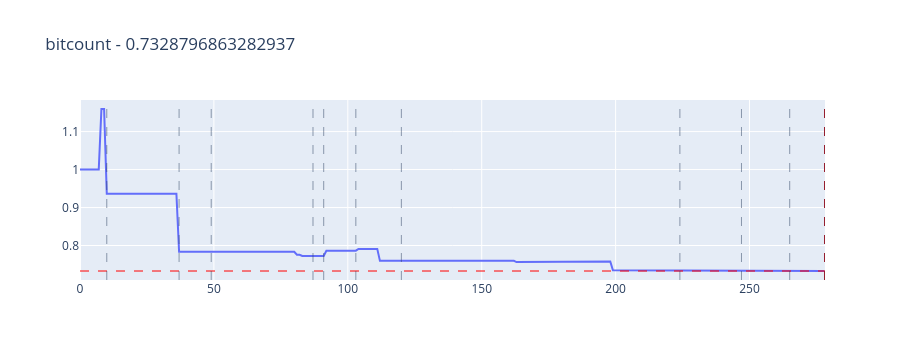

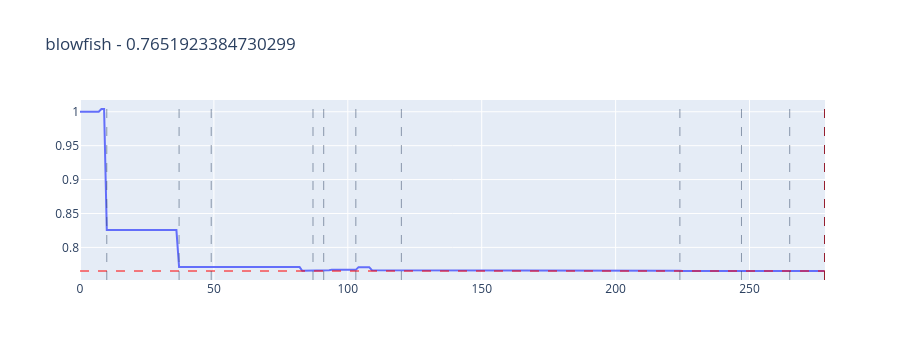

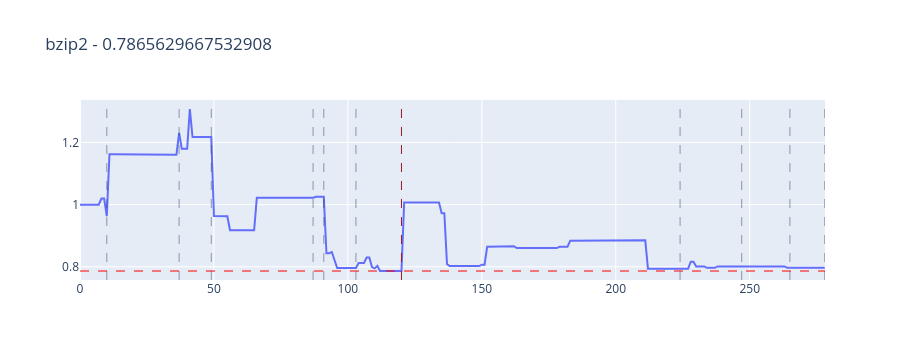

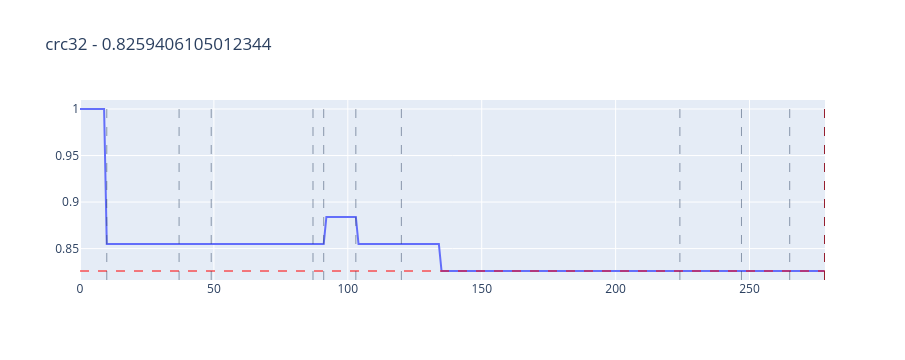

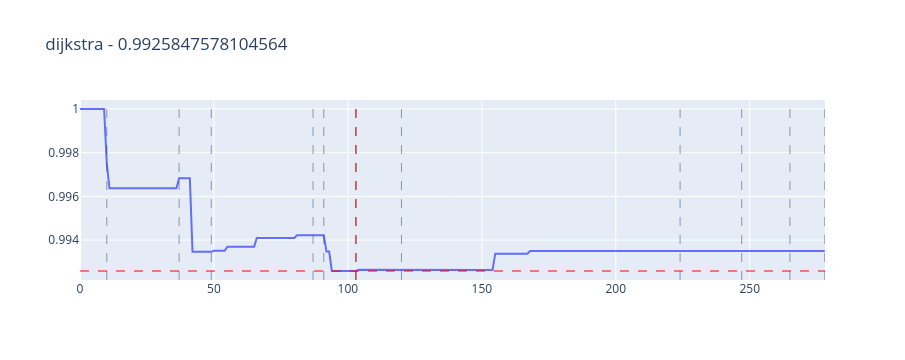

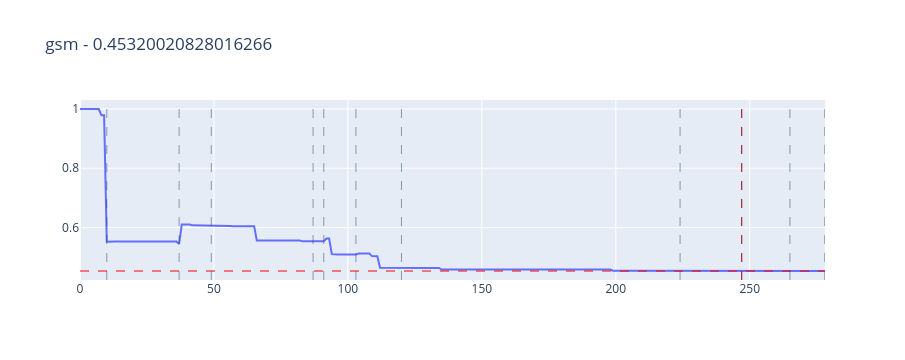

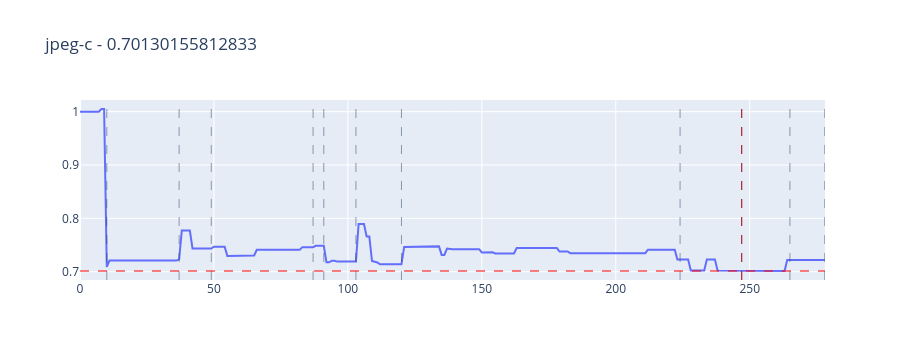

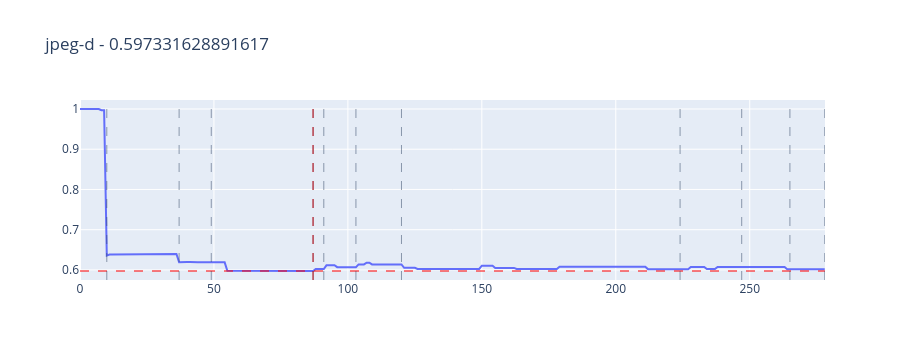

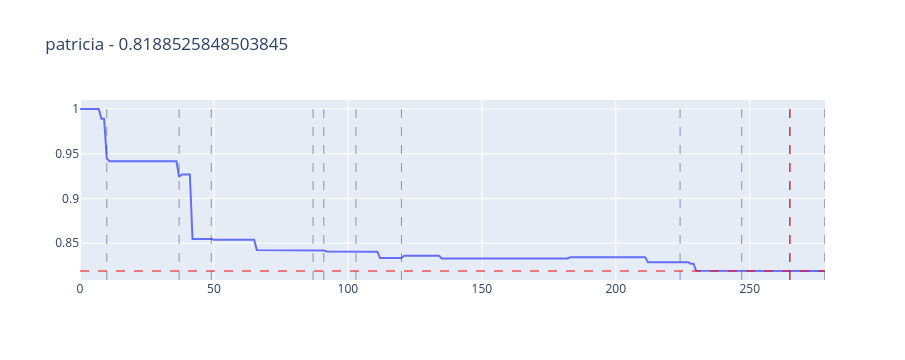

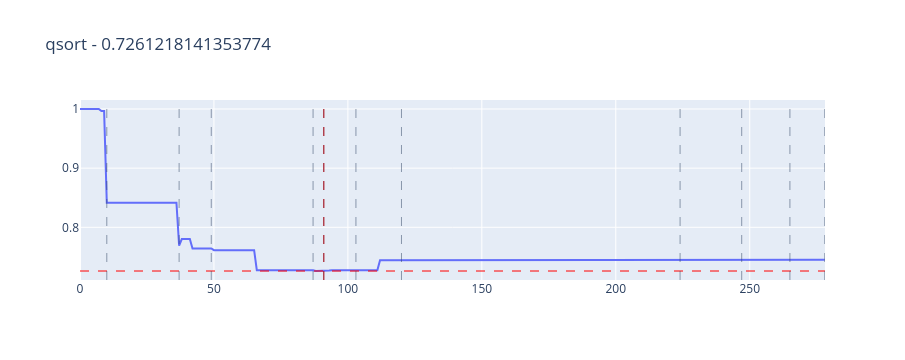

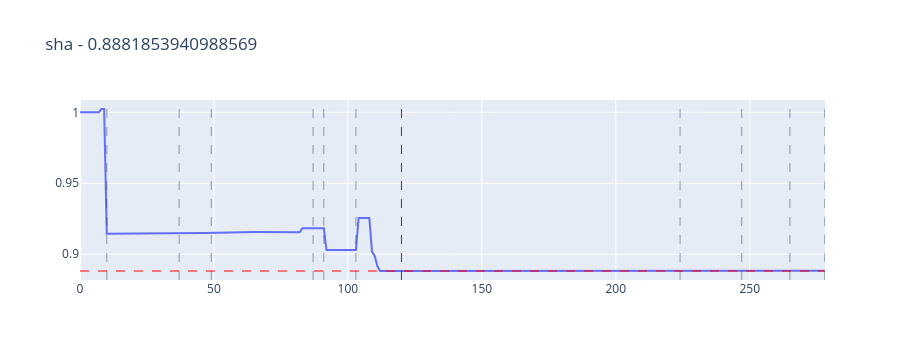

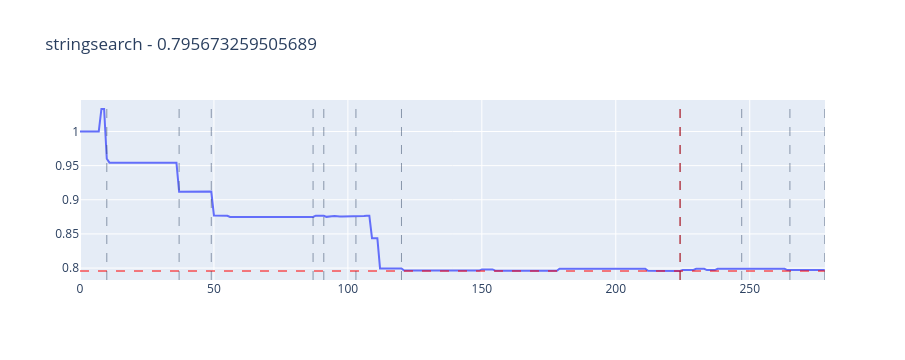

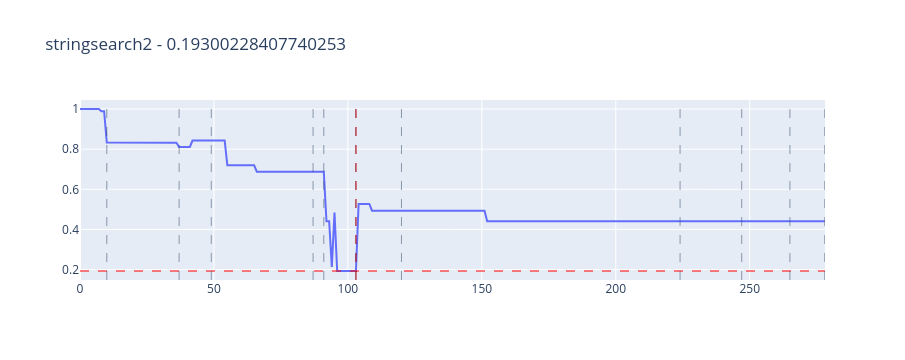

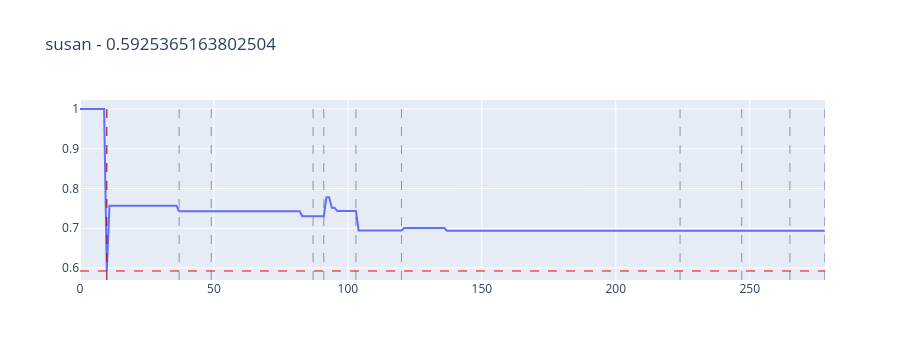

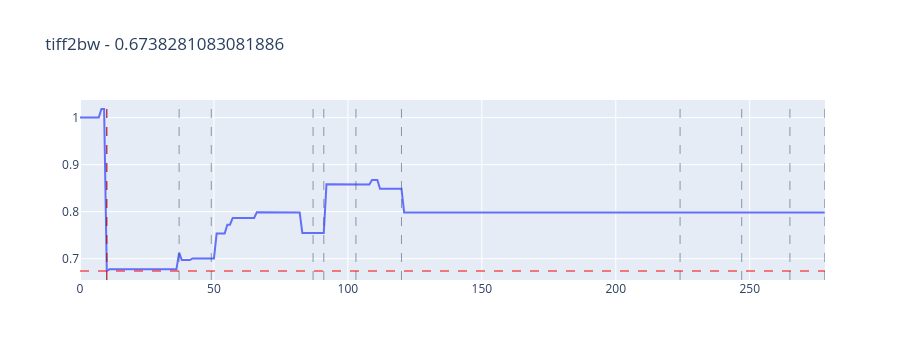

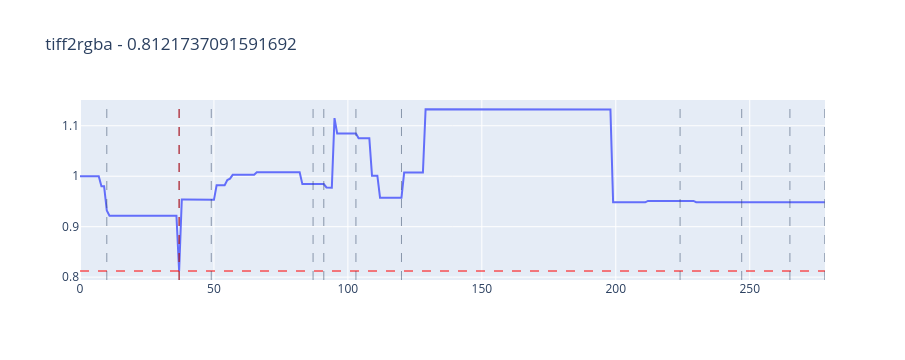

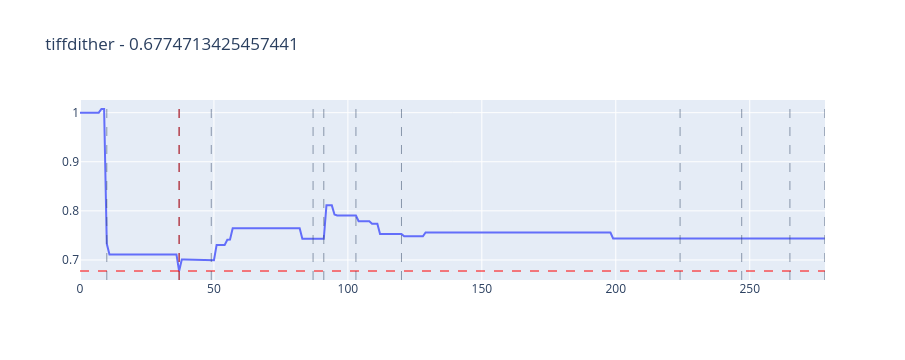

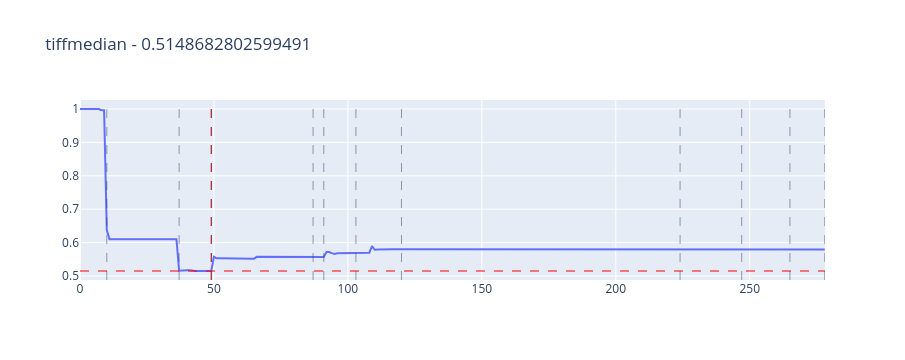

In [66]:
import plotly.graph_objects as go

agmins = []

for name, data in results.items():
    fig = go.Figure()
    if len(data) > 0:
        np_data = np.array(data)
        agmins.append(len(np_data) - np.argmin(np_data[::-1]) - 1)
        fig.add_trace(go.Scatter(y=np_data / np_data[0],
                    mode='lines',
                    # mode='lines+markers',
                    name=name))

        fig.add_hline(y=np.min(np_data / np_data[0]), line_width=1, line_dash="dash", line_color="red")
        fig.add_vline(x=agmins[-1], line_width=1, line_dash="dash", line_color="red")
    
        # for i in range(len(O3_SEQ)):
        #     if O3_SEQ[i] == "-simplifycfg":
        #         fig.add_vline(x=i + 1, line_width=0.5, line_dash="dash")
        for el in agmins_prev:
            fig.add_vline(x=el, line_width=0.5, line_dash="dash")
    
        
        fig.update_layout(
            # width=1750, height=1000
            # width=1750, height=1500
            title=f"{name} - {np_data.min()/ np_data[0]}",
        )
    fig.show()